<a href="https://colab.research.google.com/github/kundajelab/chipseqvnewtech/blob/master/H1_POU5F1_NANOG/Interpret_ChIPseq_NANOG_POU5F1_CUTNRUN_POU5F1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%bash

#Download relevant data
#For information on data prep, see https://github.com/kundajelab/chipseqvnewtech/blob/master/H1_POU5F1_NANOG/prep_data.sh
webdir=http://ec2-13-56-107-121.us-west-1.compute.amazonaws.com/chipseq_vs_newtech/H1_POU5F1_NANOG

download_if_not_there () {
  local file=$1
  [[ -f $file ]] || wget $webdir/$file -O $file
}

download_if_not_there CUTNRUN.POU5F1.5p.counts.bigWig
download_if_not_there CUTNRUN.POU5F1.maxFL120bp.5p.counts.bigWig
download_if_not_there CUTNRUN.POU5F1.minFL150bp.5p.counts.bigWig
download_if_not_there CUTNRUN.POU5F1.narrowpeak.gz
download_if_not_there CUTNRUN.IgG.standard.5p.counts.bigWig
download_if_not_there CUTNRUN.IgG.standard.maxFL120bp.5p.counts.bigWig
download_if_not_there CUTNRUN.IgG.standard.minFL150bp.5p.counts.bigWig

download_if_not_there CUTNRUN.NANOG.5p.counts.bigWig
download_if_not_there CUTNRUN.NANOG.maxFL120bp.5p.counts.bigWig
download_if_not_there CUTNRUN.NANOG.minFL150bp.5p.counts.bigWig
download_if_not_there CUTNRUN.NANOG.narrowpeak.gz
download_if_not_there CUTNRUN.IgG.merged.auto.5p.counts.bigWig
download_if_not_there CUTNRUN.IgG.merged.auto.maxFL120bp.5p.counts.bigWig
download_if_not_there CUTNRUN.IgG.merged.auto.minFL150bp.5p.counts.bigWig

download_if_not_there ChIPseq.POU5F1.merged.5p.counts.plus.bigWig
download_if_not_there ChIPseq.POU5F1.merged.5p.counts.minus.bigWig
download_if_not_there ChIPseq.POU5F1.narrowpeak.gz
download_if_not_there ChIPseq.NANOG.merged.5p.counts.plus.bigWig
download_if_not_there ChIPseq.NANOG.merged.5p.counts.minus.bigWig
download_if_not_there ChIPseq.NANOG.narrowpeak.gz
download_if_not_there ChIPseq.control.bigWig

In [0]:
#preparing the BED regions
#first concatenate peaks in the files you care about
!zcat ChIPseq.NANOG.narrowpeak.gz ChIPseq.POU5F1.narrowpeak.gz CUTNRUN.POU5F1.narrowpeak.gz | gzip -c > concatenated_peaks.narrowpeak.gz
#get 2kb around summits
!zcat concatenated_peaks.narrowpeak.gz | perl -lane 'print $F[0]."\t".(($F[1]+$F[9]))."\t".(($F[1]+$F[9]))' | bedtools slop -g hg38.chrom.sizes -b 1000 | perl -lane 'if ($F[2]-$F[1]==2000) {print $F[0]."\t".$F[1]."\t".$F[2]."\t1"}' | sortBed | gzip -c > 2k_around_summits.bed.gz
#split into train, valid, test sets by chromosome
!zcat 2k_around_summits.bed.gz | egrep -w 'chr1|chr8|chr21' | gzip -c > test_2k_around_summits.bed.gz
!zcat 2k_around_summits.bed.gz | egrep -w 'chr22' | gzip -c > valid_2k_around_summits.bed.gz
!zcat 2k_around_summits.bed.gz | egrep -w -v 'chr1|chr8|chr21|chr22' | gzip -c > train_2k_around_summits.bed.gz

In [3]:
#install software
!pip install pyfaidx
!pip install pyBigWig
!apt-get install bedtools
#installing samtools
%cd /content
![[ -f samtools-1.9.tar.bz2 ]] || wget https://github.com/samtools/samtools/releases/download/1.9/samtools-1.9.tar.bz2
!tar -xjf samtools-1.9.tar.bz2
%cd samtools-1.9
!./configure
!make
!make install
%cd ..

#download the hg38 genome, build the index
![[ -f hg38.2bit ]] || wget http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.2bit -O hg38.2bit  
![[ -f twoBitToFa ]] || wget http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/twoBitToFa -O twoBitToFa
!chmod a+x twoBitToFa
![[ -f hg38.genome.fa ]] || ./twoBitToFa hg38.2bit hg38.genome.fa
![[ -f hg38.genome.fa.fai ]] || samtools faidx hg38.genome.fa
#Download the ENCODE ebv-containing chromsizes file
![[ -f hg38.chrom.sizes ]] || wget https://raw.githubusercontent.com/ENCODE-DCC/encValData/master/GRCh38/GRCh38_EBV.chrom.sizes -O hg38.chrom.sizes

  Stored in directory: /root/.cache/pip/wheels/54/a2/b4/e242e58d23b2808e191b214067880faa46cd2341f363886e0b
Successfully built pyfaidx
     |████████████████████████████████| 71kB 26.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/d7/b9/a7/4ced1fb3a4e8816bbdc7bd3fee1d378d76e57e55ead6113976
Successfully built pyBigWig
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  bedtools
0 upgraded, 1 newly installed, 0 to remove and 4 not upgraded.
Need to get 577 kB of archives.
After this operation, 2,040 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 bedtools amd64 2.26.0+dfsg-5 [577 kB]
Fetched 577 kB in 3s (226 kB/s)
Selecting previously unselected package bedtools.
(Reading database ... 130963 files and dir

In [4]:
![[ -e seqdataloader ]] || git clone https://github.com/kundajelab/seqdataloader.git
!pip install seqdataloader/

Cloning into 'seqdataloader'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 617 (delta 68), reused 71 (delta 34), pack-reused 508
Receiving objects: 100% (617/617), 3.80 MiB | 2.36 MiB/s, done.
Resolving deltas: 100% (394/394), done.
Processing ./seqdataloader
     |████████████████████████████████| 194kB 28.8MB/s 
     |████████████████████████████████| 12.5MB 28.5MB/s 
     |████████████████████████████████| 9.6MB 38.8MB/s 
     |████████████████████████████████| 40kB 19.0MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-_8djw5cp/wheels/c2/db/13/112d41662f69fb8c7986c218293570cc1550fc21eed966e31b
  Stored in directory: /root/.cache/pip/wheels/de/22/40/f5eb4ef7cb83c890596ce90260a478008adeca4e4138f64430
  Stored in directory: /root/.cache/pip/wheels/4b/62/5b/fcd4580cc7fd70075dc142673a677bed992b5217a7ce22b973
  Stored in directory: /root/.cache/pip/wheels/51/30/d1/92a39ba40f21

In [5]:
!git clone https://github.com/kundajelab/chipseqvnewtech.git

Cloning into 'chipseqvnewtech'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 46 (delta 18), reused 8 (delta 1), pack-reused 0
Unpacking objects: 100% (46/46), done.


In [17]:
from collections import OrderedDict
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
import keras
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers

#Written by Žiga Avsec
def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))

#Written by Žiga Avsec
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}
      
#check that the model can be reloaded
#to reload, you need to set up a CustomObjectScope
from keras.utils import CustomObjectScope
from keras.models import load_model
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL}):
  loaded_model = load_model('chipseqvnewtech/H1_POU5F1_NANOG/Oct4NanogChIP_Oct4CUTNRUN_Oct4cnrpeaksincluded.h5')
  
seq_len = int(loaded_model.input[0].shape[1])
out_pred_len = int(loaded_model.output[-1].shape[1])
print("seq length",seq_len)
print("output length",out_pred_len)

#the code below is used to prepare instances of keras.utils.Sequence that
# can be supplied to model.fit_generator(...)
#Note that we log-transform our counts using np.log(counts+1)
#Also note that the profiles for the control are smoothed by windows of
# size 1 and 50 (smoothing by a window of size 1 just returns
# the original profile)
inputs_coordstovals = coordstovals.core.CoordsToValsJoiner(
    coordstovals_list=[
      coordbased.coordstovals.fasta.PyfaidxCoordsToVals(
        genome_fasta_path="hg38.genome.fa",
        mode_name="sequence",
        center_size_to_use=seq_len),
      coordstovals.bigwig.MultiTrackCountsAndProfile(
        counts_mode_name="ChIPseq.control.logcount",
        profile_mode_name="ChIPseq.control.profile",
        bigwig_paths=["ChIPseq.control.bigWig"],
        counts_and_profiles_transformer=
          coordstovals.bigwig.LogCountsPlusOne().chain(
            coordstovals.bigwig.SmoothProfiles(smoothing_windows=[1,50])),        
        center_size_to_use=out_pred_len),
     #coordstovals.bigwig.MultiTrackCountsAndProfile(
     #   counts_mode_name="CUTNRUN.control.auto.logcount",
     #   profile_mode_name="CUTNRUN.control.auto.profile",
     #   bigwig_paths=["CUTNRUN.IgG.merged.auto.5p.counts.bigWig",
     #                 "CUTNRUN.IgG.merged.auto.maxFL120bp.5p.counts.bigWig",
     #                 "CUTNRUN.IgG.merged.auto.minFL150bp.5p.counts.bigWig"],
     #   counts_and_profiles_transformer=
     #     coordstovals.bigwig.LogCountsPlusOne().chain(
     #       coordstovals.bigwig.SmoothProfiles(smoothing_windows=[1,50])),
     #   center_size_to_use=out_pred_len),
     coordstovals.bigwig.MultiTrackCountsAndProfile(
        counts_mode_name="CUTNRUN.control.standard.logcount",
        profile_mode_name="CUTNRUN.control.standard.profile",
        bigwig_paths=["CUTNRUN.IgG.standard.5p.counts.bigWig",
                      #"CUTNRUN.IgG.standard.maxFL120bp.5p.counts.bigWig",
                      #"CUTNRUN.IgG.standard.minFL150bp.5p.counts.bigWig"
                     ],
        counts_and_profiles_transformer=
          coordstovals.bigwig.LogCountsPlusOne().chain(
            coordstovals.bigwig.SmoothProfiles(smoothing_windows=[1,50])),       
        center_size_to_use=out_pred_len)
    ])
targets_coordstovals = coordstovals.core.CoordsToValsJoiner(
    coordstovals_list=[
      coordstovals.bigwig.PosAndNegSeparateLogCounts(
        counts_mode_name="ChIPseq.POU5F1.logcount",
        profile_mode_name="ChIPseq.POU5F1.profile",
        pos_strand_bigwig_path="ChIPseq.POU5F1.merged.5p.counts.plus.bigWig",
        neg_strand_bigwig_path="ChIPseq.POU5F1.merged.5p.counts.minus.bigWig",
        center_size_to_use=out_pred_len),
      coordstovals.bigwig.PosAndNegSeparateLogCounts(
        counts_mode_name="ChIPseq.NANOG.logcount",
        profile_mode_name="ChIPseq.NANOG.profile",
        pos_strand_bigwig_path="ChIPseq.NANOG.merged.5p.counts.plus.bigWig",
        neg_strand_bigwig_path="ChIPseq.NANOG.merged.5p.counts.minus.bigWig",
        center_size_to_use=out_pred_len),
      coordstovals.bigwig.MultiTrackCountsAndProfile(
        counts_mode_name="CUTNRUN.POU5F1.logcount",
        profile_mode_name="CUTNRUN.POU5F1.profile",
        bigwig_paths=["CUTNRUN.POU5F1.5p.counts.bigWig",
                      #"CUTNRUN.POU5F1.maxFL120bp.5p.counts.bigWig",
                      #"CUTNRUN.POU5F1.minFL150bp.5p.counts.bigWig"
                     ],
        counts_and_profiles_transformer=
          coordstovals.bigwig.LogCountsPlusOne().chain(
              coordstovals.bigwig.SmoothProfiles(smoothing_windows=[10])),
        center_size_to_use=out_pred_len),
      #coordstovals.bigwig.MultiTrackCountsAndProfile(
      #  counts_mode_name="CUTNRUN.NANOG.logcount",
      #  profile_mode_name="CUTNRUN.NANOG.profile",
      #  bigwig_paths=["CUTNRUN.NANOG.5p.counts.bigWig",
      #                "CUTNRUN.NANOG.maxFL120bp.5p.counts.bigWig",
      #                "CUTNRUN.NANOG.minFL150bp.5p.counts.bigWig"],
      #  counts_and_profiles_transformer=coordstovals.bigwig.LogCountsPlusOne().chain(
      #        coordstovals.bigwig.SmoothProfiles(smoothing_windows=[10])),
      #  center_size_to_use=out_pred_len)
    ])

keras_test_batch_generator = coordbased.core.KerasBatchGenerator(
  coordsbatch_producer=coordbatchproducers.SimpleCoordsBatchProducer(
            bed_file="test_2k_around_summits.bed.gz",
            batch_size=64,
            shuffle_before_epoch=False, 
            seed=1234),
  inputs_coordstovals=inputs_coordstovals,
  targets_coordstovals=targets_coordstovals)

seq length 1346
output length 1000


In [0]:
import numpy as np

def extend_generator(generator):
  samp_inputs, samp_targets = generator[0]
  concat_inputs = OrderedDict([(key, []) for key in samp_inputs.keys()])
  concat_targets = OrderedDict([(key, []) for key in samp_targets.keys()])
  for batch_idx in range(len(generator)):
    batch_inputs, batch_targets = generator[batch_idx]
    for key in batch_inputs:
      concat_inputs[key].extend(batch_inputs[key])
    for key in batch_targets:
      concat_targets[key].extend(batch_targets[key])
  for key in concat_inputs:
    concat_inputs[key] = np.array(concat_inputs[key])
  for key in concat_targets:
    concat_targets[key] = np.array(concat_targets[key])
  return (concat_inputs, concat_targets)

test_inputs, test_targets = extend_generator(keras_test_batch_generator)      

In [0]:
test_preds = OrderedDict(zip(loaded_model.output_names, loaded_model.predict(test_inputs)))

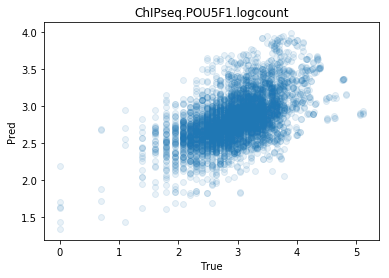

SpearmanrResult(correlation=0.5488101936918638, pvalue=0.0)


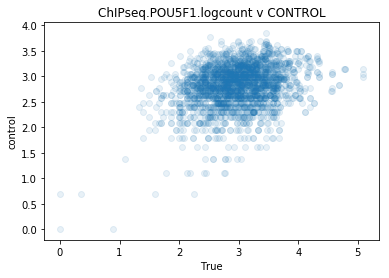

SpearmanrResult(correlation=0.22574404754578856, pvalue=4.1210635700111105e-28)


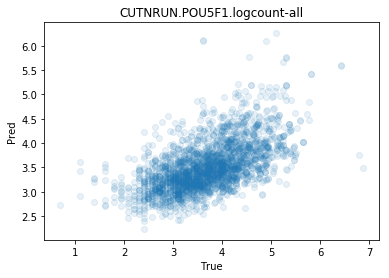

SpearmanrResult(correlation=0.5945533452203494, pvalue=3.6500643400277943e-221)


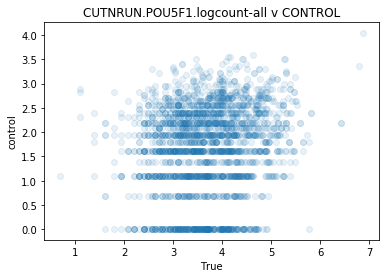

SpearmanrResult(correlation=0.14305510171382513, pvalue=4.781999652141459e-12)


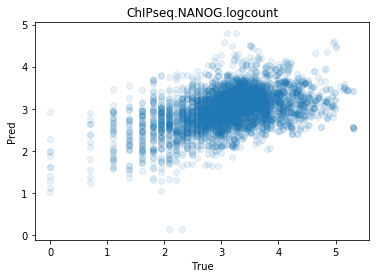

SpearmanrResult(correlation=0.4339248393237135, pvalue=9.236639726353446e-212)


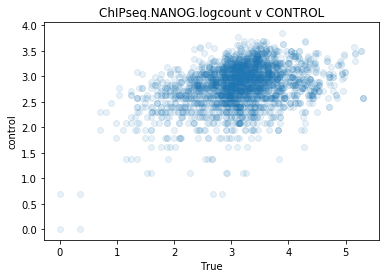

SpearmanrResult(correlation=0.316747792009793, pvalue=4.58417138279299e-55)


In [20]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, pearsonr

def plot_scatter(xvals, yvals, xlabel, ylabel, title):
  plt.scatter(xvals, yvals, alpha=0.1)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()
  print(spearmanr(xvals,yvals))
  
plot_scatter(xvals=test_targets['ChIPseq.POU5F1.logcount'].ravel(),
             yvals=test_preds['ChIPseq.POU5F1.logcount'].ravel(),
             xlabel="True", ylabel="Pred", title="ChIPseq.POU5F1.logcount")
plot_scatter(xvals=np.mean(test_targets['ChIPseq.POU5F1.logcount'],axis=-1),
             yvals=test_inputs['ChIPseq.control.logcount'],
             xlabel="True", ylabel="control", title="ChIPseq.POU5F1.logcount v CONTROL")

plot_scatter(xvals=test_targets['CUTNRUN.POU5F1.logcount'][:,0],
             yvals=test_preds['CUTNRUN.POU5F1.logcount'][:,0],
             xlabel="True", ylabel="Pred", title="CUTNRUN.POU5F1.logcount-all")
plot_scatter(xvals=test_targets['CUTNRUN.POU5F1.logcount'][:,0],
             yvals=test_inputs['CUTNRUN.control.standard.logcount'][:,0],
             xlabel="True", ylabel="control", title="CUTNRUN.POU5F1.logcount-all v CONTROL")

plot_scatter(xvals=test_targets['ChIPseq.NANOG.logcount'].ravel(),
             yvals=test_preds['ChIPseq.NANOG.logcount'].ravel(),
             xlabel="True", ylabel="Pred", title="ChIPseq.NANOG.logcount")
plot_scatter(xvals=np.mean(test_targets['ChIPseq.NANOG.logcount'],axis=-1),
             yvals=test_inputs['ChIPseq.control.logcount'],
             xlabel="True", ylabel="control", title="ChIPseq.NANOG.logcount v CONTROL")  

#plot_scatter(xvals=test_targets['CUTNRUN.NANOG.logcount'][:,0],
#             yvals=test_preds['CUTNRUN.NANOG.logcount'][:,0],
#             xlabel="True", ylabel="Pred", title="CUTNRUN.NANOG.logcount-all")
#plot_scatter(xvals=test_targets['CUTNRUN.NANOG.logcount'][:,0],
#             yvals=test_inputs['CUTNRUN.control.auto.logcount'][:,0],
#             xlabel="True", ylabel="control", title="CUTNRUN.NANOG.logcount-all v CONTROL")

1601
NANOG ChIPseq preds


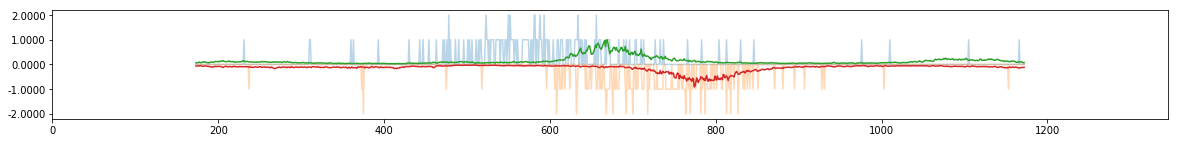

POU5F1 ChIPseq preds


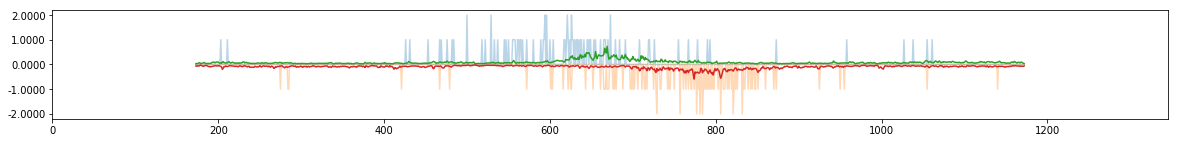

POU5F1 CUTNRUN preds


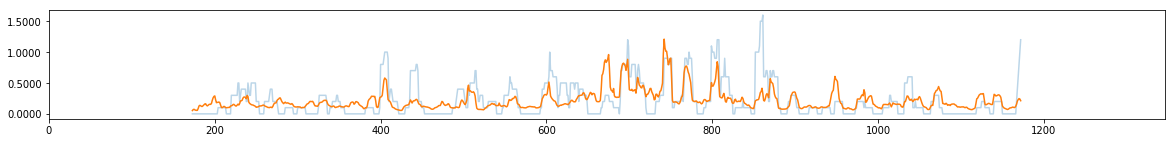

1602
NANOG ChIPseq preds


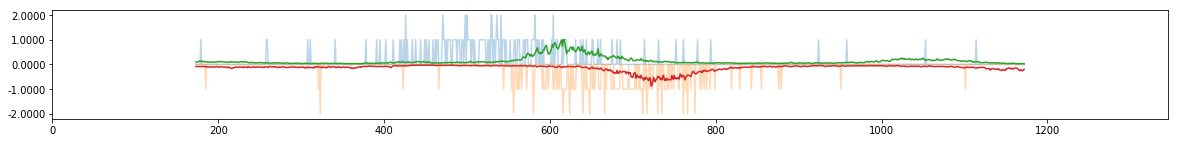

POU5F1 ChIPseq preds


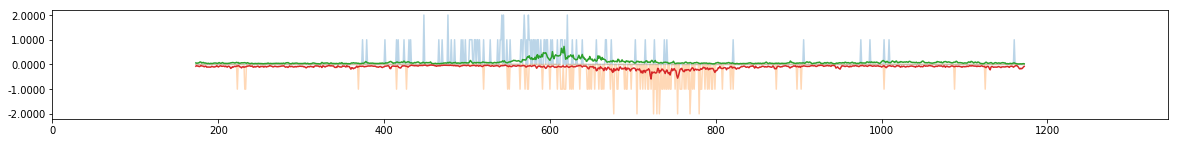

POU5F1 CUTNRUN preds


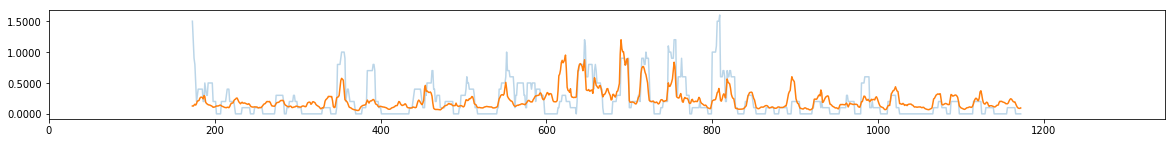

1600
NANOG ChIPseq preds


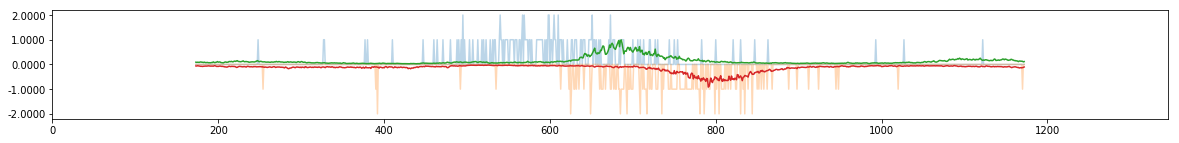

POU5F1 ChIPseq preds


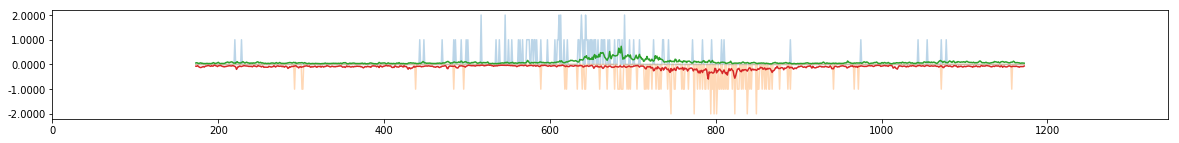

POU5F1 CUTNRUN preds


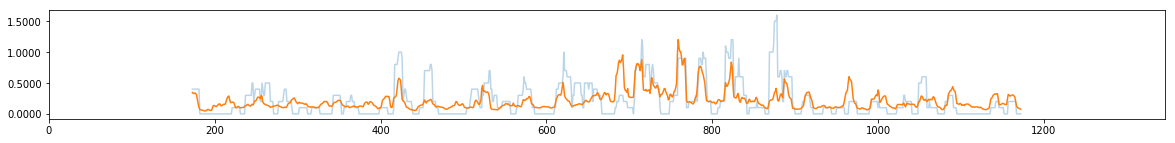

1923
NANOG ChIPseq preds


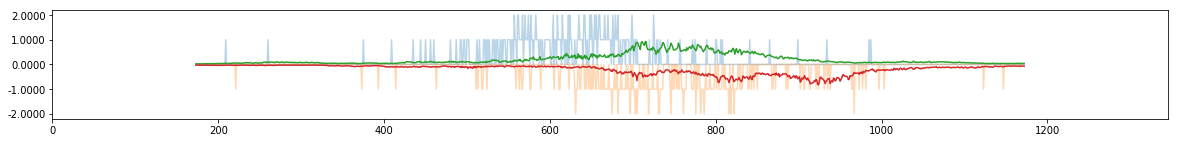

POU5F1 ChIPseq preds


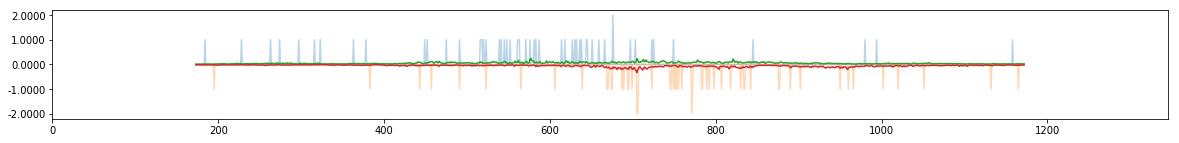

POU5F1 CUTNRUN preds


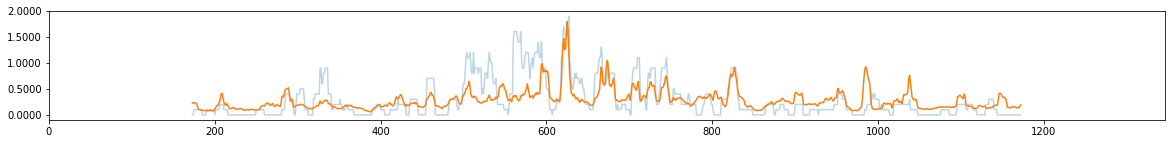

1924
NANOG ChIPseq preds


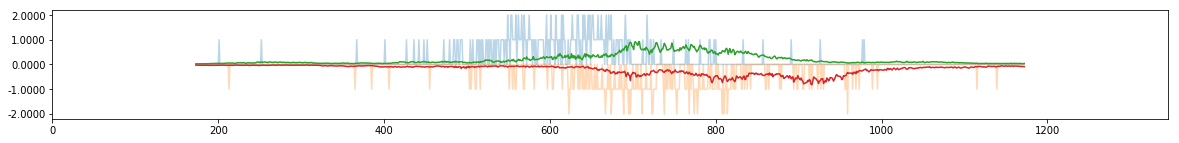

POU5F1 ChIPseq preds


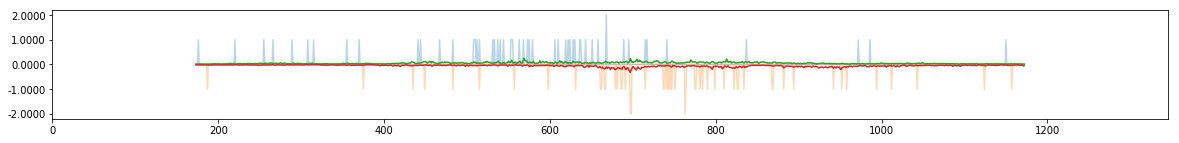

POU5F1 CUTNRUN preds


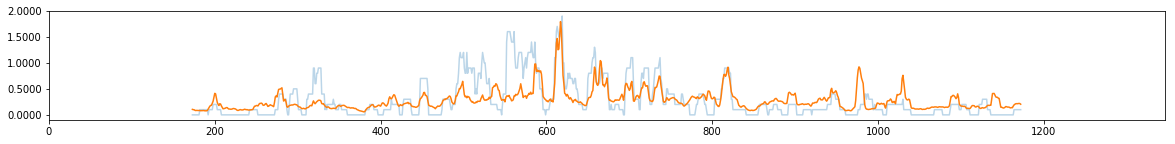

1922
NANOG ChIPseq preds


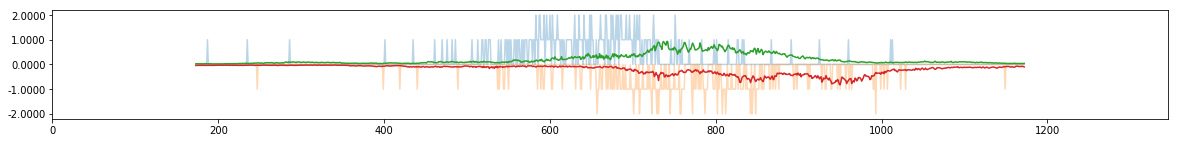

POU5F1 ChIPseq preds


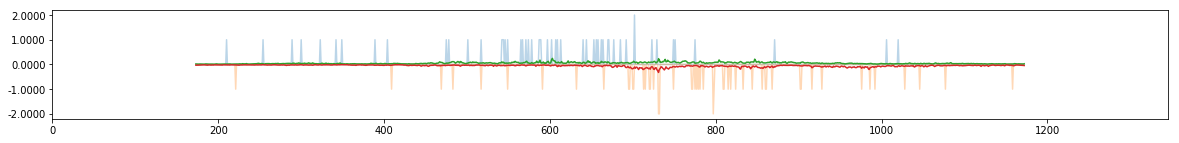

POU5F1 CUTNRUN preds


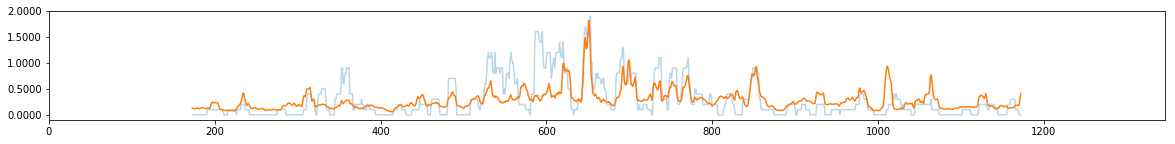

338
NANOG ChIPseq preds


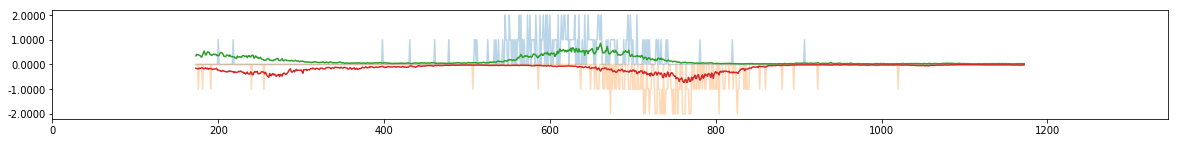

POU5F1 ChIPseq preds


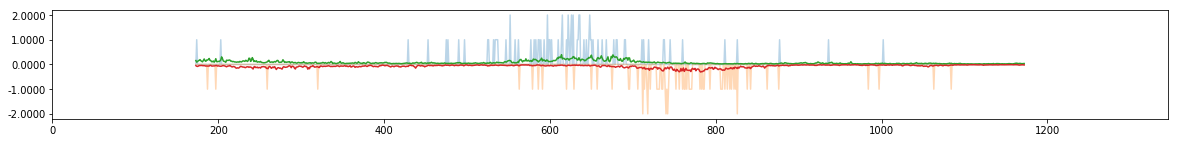

POU5F1 CUTNRUN preds


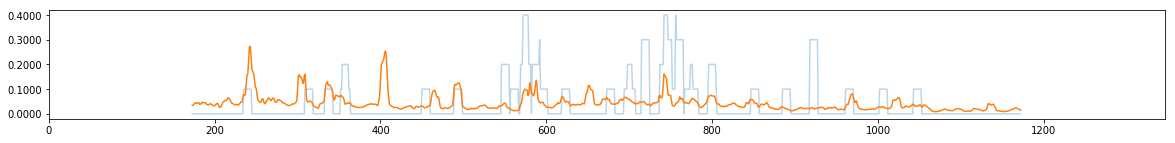

339
NANOG ChIPseq preds


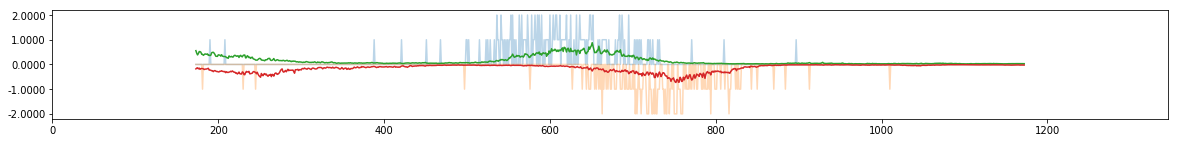

POU5F1 ChIPseq preds


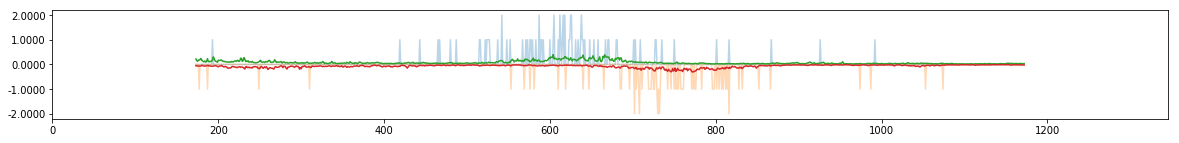

POU5F1 CUTNRUN preds


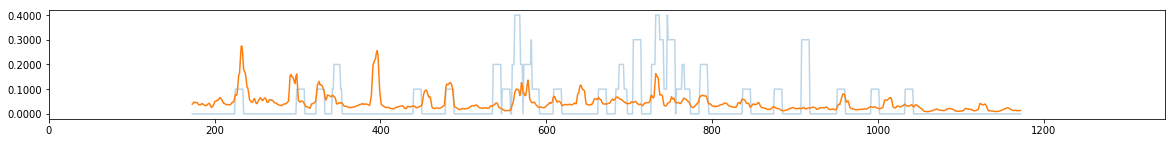

102
NANOG ChIPseq preds


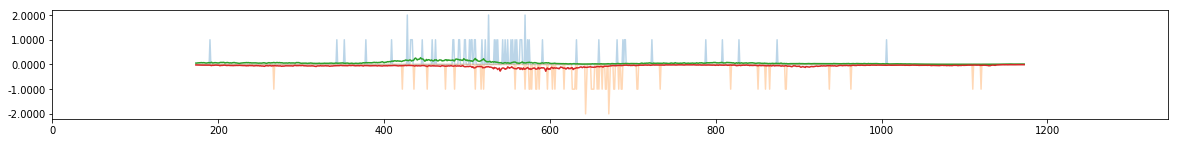

POU5F1 ChIPseq preds


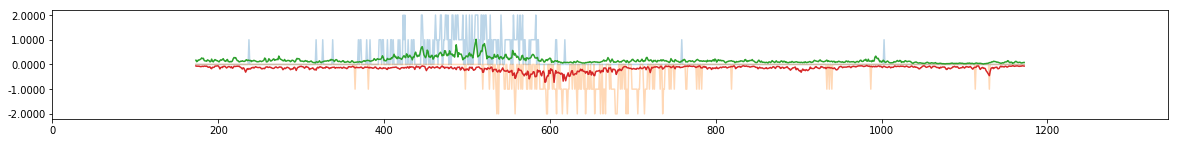

POU5F1 CUTNRUN preds


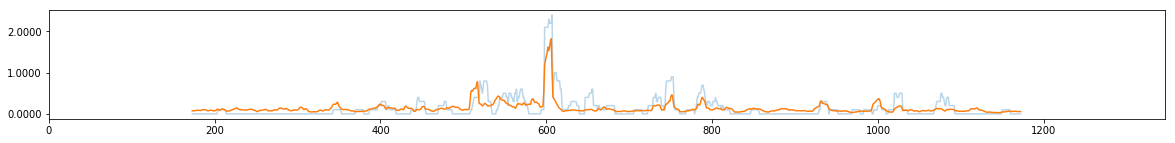

100
NANOG ChIPseq preds


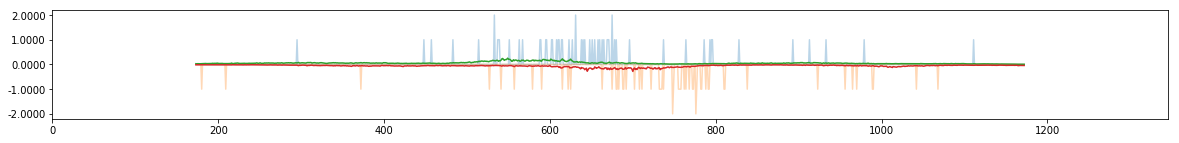

POU5F1 ChIPseq preds


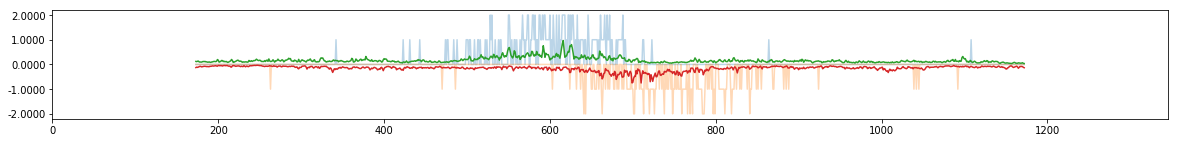

POU5F1 CUTNRUN preds


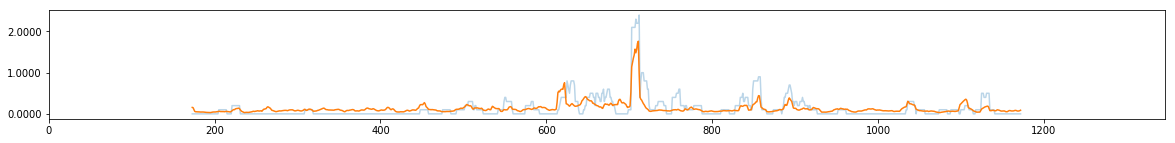

In [21]:
from matplotlib.ticker import FormatStrFormatter

#sort indices by NANOG counts
sorted_nanog_counts = [x[0] for x in 
                       sorted(enumerate(np.sum(test_targets['ChIPseq.NANOG.logcount'],axis=-1)
                                        +np.sum(test_targets['ChIPseq.POU5F1.logcount'],axis=-1)),
                              key=lambda x: -x[1])]
def plot_profile(true_profile, pred_profile_logits):
  pred_profile = (np.sum(true_profile, axis=0)[None,:] #total counts
                  *(np.exp(pred_profile_logits)/
                    np.sum(np.exp(pred_profile_logits),axis=0)[None,:]) )
  plt.figure(figsize=(20,2))     
  total_flanking = seq_len - out_pred_len
  left_flank = int(0.5*total_flanking)
  right_flank = total_flanking - left_flank
  plt.plot(np.arange(out_pred_len)+left_flank, true_profile[:,0], alpha=0.3)
  if (true_profile.shape[1] == 2):
    plt.plot(np.arange(out_pred_len)+left_flank, -true_profile[:,1], alpha=0.3)
  plt.plot(np.arange(out_pred_len)+left_flank, pred_profile[:,0])
  if (true_profile.shape[1] == 2):
    plt.plot(np.arange(out_pred_len)+left_flank, -pred_profile[:,1])
  plt.xlim(0,seq_len)
  plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
  plt.show()

for idx in sorted_nanog_counts[:10]:
  print(idx)
  print("NANOG ChIPseq preds")
  plot_profile(true_profile=test_targets['ChIPseq.NANOG.profile'][idx],
                         pred_profile_logits=test_preds['ChIPseq.NANOG.profile'][idx])
  print("POU5F1 ChIPseq preds")
  plot_profile(true_profile=test_targets['ChIPseq.POU5F1.profile'][idx],
                         pred_profile_logits=test_preds['ChIPseq.POU5F1.profile'][idx])
  print("POU5F1 CUTNRUN preds")
  plot_profile(true_profile=test_targets['CUTNRUN.POU5F1.profile'][idx],
                         pred_profile_logits=test_preds['CUTNRUN.POU5F1.profile'][idx])